In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from loadData import *
from proportion import *

os.chdir('../')

dataxls = loadXLS()

lstTrain, lstVal, lstTest, yTrain, yVal, yTest = lstTrainValTestCDR(dataxls=dataxls)

dataTrain, dataVal, dataTest = loadData(dataxls=dataxls)



In [ ]:

def get_model(width=256, height=256, depth=128):
    "Build a 3D convolutional neural network model."

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    #x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    #x = layers.MaxPool3D(pool_size=2)(x)
    #x = layers.BatchNormalization()(x)

    #x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    #x = layers.MaxPool3D(pool_size=2)(x)
    #x = layers.BatchNormalization()(x)

    #x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    #x = layers.MaxPool3D(pool_size=2)(x)
    #x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model

# Build model
model = get_model(width=256, height=256, depth=128)
model.summary()

initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

# Compile model
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 128, 1  0         
                             )]                                  
                                                                 
 conv3d (Conv3D)             (None, 254, 254, 126, 64  1792      
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 127, 127, 63, 64)  0        
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 63, 64)  256      
 ormalization)                                                   
                                                                 
 global_average_pooling3d (G  (None, 64)               0     

2022-11-07 13:26:11.818921: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)


# Fit model
model.fit(
    x=dataTrain[0:2,:,:,:,:],
    y=yTrain[0:2,:],
    validation_data=(dataVal, yVal),
    epochs=2,
    batch_size=32,
    #shuffle=True,
    verbose='auto',
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/2
1/1 [==============================] - 378s 378s/step - loss: 0.6924 - acc: 0.5000
Epoch 2/2


KeyError: 'val_acc'

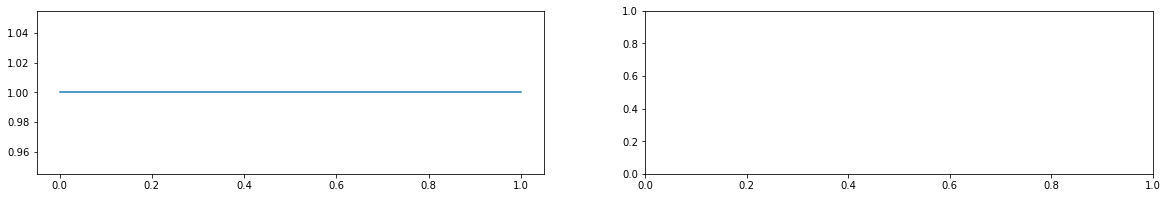

In [ ]:
# Results
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

plt.show()  